In [111]:
%matplotlib inline

Visualization of classification and regression analyses on March 2019 release of CIMAQ fMRI data.

In [112]:
import os
import sys
import glob
import numpy as np
import pandas as pd
import nilearn
import scipy
import nibabel as nb
import sklearn
import seaborn as sns
import itertools

from numpy import nan as NaN
from matplotlib import pyplot as plt
from matplotlib import axes, collections
from matplotlib.collections import PathCollection
from nilearn import image, plotting
from nilearn import masking
from nilearn import plotting
from nilearn import datasets
from nilearn.plotting import plot_stat_map, plot_roi, plot_anat, plot_img, show
from nilearn.input_data import NiftiMasker, NiftiLabelsMasker
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, f1_score
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.preprocessing import MinMaxScaler


Within subject classification 

In [113]:
data_dir = '/Users/mombot/Documents/Simexp/CIMAQ/Data/Nilearn/Group_results'
analyses = ['7networks', '20networks', '64networks', '325networks', '444networks', 'wholeBrain']
netnames = ['7', '20', '64', '325', '444', 'WB']

In [42]:
# ENCODING vs CONTROL Conditions: trial classification

contrast = 'enc_ctl_'

enc_ctl7 = pd.read_csv(os.path.join(data_dir, 'SVC_withinSub_enc_ctl_7networks.tsv'), sep = '\t')

cols = ['dccid', 'cognitive_status', 'total_scrubbed_frames', 'mean_FD', 'hits', 'miss', 
        'correct_source', 'wrong_source', 'dprime', 'associative_memScore']

#print(enc_ctl7.columns)
enc_ctl = enc_ctl7[cols]

for i in range (0, len(analyses)):
    netnum = analyses[i]
    netname = netnames[i]
    data = pd.read_csv(os.path.join(data_dir, 'SVC_withinSub_'+contrast+netnum+'.tsv'), sep = '\t')
#    enc_ctl.insert(loc = enc_ctl.shape[1], column = netname+'_dccid', value = data['dccid'], allow_duplicates=True)
    enc_ctl.insert(loc = enc_ctl.shape[1], column = netname+'_TrainSet_MeanCV_acc', value = data['TrainSet_MeanCV_acc'], allow_duplicates=True)
    enc_ctl.insert(loc = enc_ctl.shape[1], column = netname+'_TestSet_acc', value = data['TestSet_acc'], allow_duplicates=True)

enc_ctl.insert(loc = enc_ctl.shape[1], column = '1Ctl_2SDC_3MCI', value = 0, allow_duplicates=True)

ind = enc_ctl[enc_ctl['cognitive_status']=='Controls'].index
enc_ctl.loc[ind, '1Ctl_2SDC_3MCI']=1
ind = enc_ctl[enc_ctl['cognitive_status']=='SCD'].index
enc_ctl.loc[ind, '1Ctl_2SDC_3MCI']=2
ind = enc_ctl[enc_ctl['cognitive_status']=='MCI'].index
enc_ctl.loc[ind, '1Ctl_2SDC_3MCI']=3

enc_ctl.insert(loc = enc_ctl.shape[1], column = 'HM_abs_diff', value = -1, allow_duplicates=True)
enc_ctl.insert(loc = enc_ctl.shape[1], column = 'CW_abs_diff', value = -1, allow_duplicates=True)
enc_ctl.insert(loc = enc_ctl.shape[1], column = 'CM_abs_diff', value = -1, allow_duplicates=True)

ind = enc_ctl.index
enc_ctl.loc[ind, 'HM_abs_diff'] = abs(enc_ctl.loc[ind, 'hits'] - enc_ctl.loc[ind, 'miss'])
enc_ctl.loc[ind, 'CW_abs_diff'] = abs(enc_ctl.loc[ind, 'correct_source'] - enc_ctl.loc[ind, 'wrong_source'])
enc_ctl.loc[ind, 'CM_abs_diff'] = abs(enc_ctl.loc[ind, 'correct_source'] - enc_ctl.loc[ind, 'miss'])

#print(enc_ctl.shape)
#print(enc_ctl.iloc[:, [0, 4, 5, 6, 7, 23, 24, 25]])
#print(enc_ctl['dccid']==enc_ctl['7_dccid'])
#print(enc_ctl['dccid']==enc_ctl['20_dccid'])
#print(enc_ctl['dccid']==enc_ctl['64_dccid'])
#print(enc_ctl['dccid']==enc_ctl['325_dccid'])
#print(enc_ctl['dccid']==enc_ctl['444_dccid'])
#print(enc_ctl['dccid']==enc_ctl['WB_dccid'])


In [86]:
enc_ctl_res = enc_ctl.iloc[:, 10:22].copy()

print(enc_ctl_res.shape, enc_ctl_res.std())



(94, 12) 7_TrainSet_MeanCV_acc      0.102082
7_TestSet_acc              0.107734
20_TrainSet_MeanCV_acc     0.114503
20_TestSet_acc             0.100392
64_TrainSet_MeanCV_acc     0.107141
64_TestSet_acc             0.096688
325_TrainSet_MeanCV_acc    0.086792
325_TestSet_acc            0.088426
444_TrainSet_MeanCV_acc    0.087009
444_TestSet_acc            0.086051
WB_TrainSet_MeanCV_acc     0.072562
WB_TestSet_acc             0.091510
dtype: float64
78


In [106]:
# HIT vs MISS trials classification

contrast = 'hit_miss_'

hit_miss7 = pd.read_csv(os.path.join(data_dir, 'SVC_withinSub_hit_miss_7networks.tsv'), sep = '\t')

cols = ['dccid', 'cognitive_status', 'total_scrubbed_frames', 'mean_FD', 'hits', 'miss', 
        'correct_source', 'wrong_source', 'dprime', 'associative_memScore']

#print(enc_ctl7.columns)
hit_miss = hit_miss7[cols]

for i in range (0, len(analyses)):
    netnum = analyses[i]
    netname = netnames[i]
    data = pd.read_csv(os.path.join(data_dir, 'SVC_withinSub_'+contrast+netnum+'.tsv'), sep = '\t')
#    hit_miss.insert(loc = hit_miss.shape[1], column = netname+'_dccid', value = data['dccid'], allow_duplicates=True)
    hit_miss.insert(loc = hit_miss.shape[1], column = netname+'_TrainSet_MeanCV_acc', value = data['TrainSet_MeanCV_acc'], allow_duplicates=True)
    hit_miss.insert(loc = hit_miss.shape[1], column = netname+'_TestSet_acc', value = data['TestSet_acc'], allow_duplicates=True)

hit_miss.insert(loc = hit_miss.shape[1], column = '1Ctl_2SDC_3MCI', value = 0, allow_duplicates=True)

ind = hit_miss[hit_miss['cognitive_status']=='Controls'].index
hit_miss.loc[ind, '1Ctl_2SDC_3MCI']=1
ind = hit_miss[hit_miss['cognitive_status']=='SCD'].index
hit_miss.loc[ind, '1Ctl_2SDC_3MCI']=2
ind = hit_miss[hit_miss['cognitive_status']=='MCI'].index
hit_miss.loc[ind, '1Ctl_2SDC_3MCI']=3

hit_miss.insert(loc = hit_miss.shape[1], column = 'HM_abs_diff', value = -1, allow_duplicates=True)
hit_miss.insert(loc = hit_miss.shape[1], column = 'CW_abs_diff', value = -1, allow_duplicates=True)
hit_miss.insert(loc = hit_miss.shape[1], column = 'CM_abs_diff', value = -1, allow_duplicates=True)

ind = hit_miss.index
hit_miss.loc[ind, 'HM_abs_diff'] = abs(hit_miss.loc[ind, 'hits'] - hit_miss.loc[ind, 'miss'])
hit_miss.loc[ind, 'CW_abs_diff'] = abs(hit_miss.loc[ind, 'correct_source'] - hit_miss.loc[ind, 'wrong_source'])
hit_miss.loc[ind, 'CM_abs_diff'] = abs(hit_miss.loc[ind, 'correct_source'] - hit_miss.loc[ind, 'miss'])

#print(hit_miss.shape)
#print(hit_miss.iloc[:, [0, 1, 22]])    
#print(hit_miss.iloc[:, [0, 4, 5, 6, 7, 23, 24, 25]])
    
#print(hit_miss['dccid']==hit_miss['7_dccid'])
#print(hit_miss['dccid']==hit_miss['20_dccid'])
#print(hit_miss['dccid']==hit_miss['64_dccid'])
#print(hit_miss['dccid']==hit_miss['325_dccid'])
#print(hit_miss['dccid']==hit_miss['444_dccid'])
#print(hit_miss['dccid']==hit_miss['WB_dccid'])


In [107]:
hit_miss_res = hit_miss.iloc[:, 10:22].copy()

print(hit_miss_res.mean())
print(hit_miss_res.shape, hit_miss_res.std())

print(hit_miss['hits'].min(), hit_miss['hits'].max())
print(hit_miss['miss'].min(), hit_miss['miss'].max())

7_TrainSet_MeanCV_acc      0.539067
7_TestSet_acc              0.545404
20_TrainSet_MeanCV_acc     0.564489
20_TestSet_acc             0.581162
64_TrainSet_MeanCV_acc     0.571435
64_TestSet_acc             0.586898
325_TrainSet_MeanCV_acc    0.612731
325_TestSet_acc            0.587262
444_TrainSet_MeanCV_acc    0.609284
444_TestSet_acc            0.581192
WB_TrainSet_MeanCV_acc     0.616167
WB_TestSet_acc             0.610923
dtype: float64
(42, 12) 7_TrainSet_MeanCV_acc      0.093202
7_TestSet_acc              0.094505
20_TrainSet_MeanCV_acc     0.075390
20_TestSet_acc             0.088701
64_TrainSet_MeanCV_acc     0.109590
64_TestSet_acc             0.075048
325_TrainSet_MeanCV_acc    0.115648
325_TestSet_acc            0.084013
444_TrainSet_MeanCV_acc    0.088597
444_TestSet_acc            0.097075
WB_TrainSet_MeanCV_acc     0.091826
WB_TestSet_acc             0.104484
dtype: float64
29 63
15 49


In [78]:
# CORRECT SOURCE vs WRONG SOURCE trials classification

contrast = 'cs_ws_'

cs_ws7 = pd.read_csv(os.path.join(data_dir, 'SVC_withinSub_cs_ws_7networks.tsv'), sep = '\t')

cols = ['dccid', 'cognitive_status', 'total_scrubbed_frames', 'mean_FD', 'hits', 'miss', 
        'correct_source', 'wrong_source', 'dprime', 'associative_memScore']

#print(enc_ctl7.columns)
cs_ws = cs_ws7[cols]

for i in range (0, len(analyses)):
    netnum = analyses[i]
    netname = netnames[i]
    data = pd.read_csv(os.path.join(data_dir, 'SVC_withinSub_'+contrast+netnum+'.tsv'), sep = '\t')
#    cs_ws.insert(loc = cs_ws.shape[1], column = netname+'_dccid', value = data['dccid'], allow_duplicates=True)
    cs_ws.insert(loc = cs_ws.shape[1], column = netname+'_TrainSet_MeanCV_acc', value = data['TrainSet_MeanCV_acc'], allow_duplicates=True)
    cs_ws.insert(loc = cs_ws.shape[1], column = netname+'_TestSet_acc', value = data['TestSet_acc'], allow_duplicates=True)

cs_ws.insert(loc = cs_ws.shape[1], column = '1Ctl_2SDC_3MCI', value = 0, allow_duplicates=True)

ind = cs_ws[cs_ws['cognitive_status']=='Controls'].index
cs_ws.loc[ind, '1Ctl_2SDC_3MCI']=1
ind = cs_ws[cs_ws['cognitive_status']=='SCD'].index
cs_ws.loc[ind, '1Ctl_2SDC_3MCI']=2
ind = cs_ws[cs_ws['cognitive_status']=='MCI'].index
cs_ws.loc[ind, '1Ctl_2SDC_3MCI']=3

cs_ws.insert(loc = cs_ws.shape[1], column = 'HM_abs_diff', value = -1, allow_duplicates=True)
cs_ws.insert(loc = cs_ws.shape[1], column = 'CW_abs_diff', value = -1, allow_duplicates=True)
cs_ws.insert(loc = cs_ws.shape[1], column = 'CM_abs_diff', value = -1, allow_duplicates=True)

ind = cs_ws.index
cs_ws.loc[ind, 'HM_abs_diff'] = abs(cs_ws.loc[ind, 'hits'] - cs_ws.loc[ind, 'miss'])
cs_ws.loc[ind, 'CW_abs_diff'] = abs(cs_ws.loc[ind, 'correct_source'] - cs_ws.loc[ind, 'wrong_source'])
cs_ws.loc[ind, 'CM_abs_diff'] = abs(cs_ws.loc[ind, 'correct_source'] - cs_ws.loc[ind, 'miss'])

#print(hit_miss.shape)
#print(hit_miss.iloc[:, [0, 1, 22]])    
#print(hit_miss.iloc[:, [0, 4, 5, 6, 7, 23, 24, 25]])
#print(cs_ws.shape)
#print(cs_ws.iloc[:, [0, 1, 22]]) 
#print(cs_ws['dccid']==cs_ws['7_dccid'])
#print(cs_ws['dccid']==cs_ws['20_dccid'])
#print(cs_ws['dccid']==cs_ws['64_dccid'])
#print(cs_ws['dccid']==cs_ws['325_dccid'])
#print(cs_ws['dccid']==cs_ws['444_dccid'])
#print(cs_ws['dccid']==cs_ws['WB_dccid'])


In [91]:
cs_ws_res = cs_ws.iloc[:, 10:22].copy()

print(cs_ws_res.mean())
print(cs_ws_res.shape, cs_ws_res.std())

print(cs_ws['correct_source'].min(), cs_ws['correct_source'].max())
print(cs_ws['wrong_source'].min(), cs_ws['wrong_source'].max(), cs_ws.shape)

7_TrainSet_MeanCV_acc      0.512602
7_TestSet_acc              0.509975
20_TrainSet_MeanCV_acc     0.517611
20_TestSet_acc             0.529818
64_TrainSet_MeanCV_acc     0.543622
64_TestSet_acc             0.538483
325_TrainSet_MeanCV_acc    0.546515
325_TestSet_acc            0.568643
444_TrainSet_MeanCV_acc    0.551398
444_TestSet_acc            0.588626
WB_TrainSet_MeanCV_acc     0.564483
WB_TestSet_acc             0.576609
dtype: float64
(49, 12) 7_TrainSet_MeanCV_acc      0.127680
7_TestSet_acc              0.122187
20_TrainSet_MeanCV_acc     0.116681
20_TestSet_acc             0.114300
64_TrainSet_MeanCV_acc     0.105738
64_TestSet_acc             0.098037
325_TrainSet_MeanCV_acc    0.142027
325_TestSet_acc            0.116045
444_TrainSet_MeanCV_acc    0.109290
444_TestSet_acc            0.099712
WB_TrainSet_MeanCV_acc     0.102101
WB_TestSet_acc             0.107496
dtype: float64
15 61
15 44 (49, 26)


In [80]:
# CORRECT SOURCE vs MISS trials classification

contrast = 'cs_miss_'

cs_miss7 = pd.read_csv(os.path.join(data_dir, 'SVC_withinSub_cs_miss_7networks.tsv'), sep = '\t')

cols = ['dccid', 'cognitive_status', 'total_scrubbed_frames', 'mean_FD', 'hits', 'miss', 
        'correct_source', 'wrong_source', 'dprime', 'associative_memScore']

#print(enc_ctl7.columns)
cs_miss = cs_miss7[cols]

for i in range (0, len(analyses)):
    netnum = analyses[i]
    netname = netnames[i]
    data = pd.read_csv(os.path.join(data_dir, 'SVC_withinSub_'+contrast+netnum+'.tsv'), sep = '\t')
#    cs_miss.insert(loc = cs_miss.shape[1], column = netname+'_dccid', value = data['dccid'], allow_duplicates=True)
    cs_miss.insert(loc = cs_miss.shape[1], column = netname+'_TrainSet_MeanCV_acc', value = data['TrainSet_MeanCV_acc'], allow_duplicates=True)
    cs_miss.insert(loc = cs_miss.shape[1], column = netname+'_TestSet_acc', value = data['TestSet_acc'], allow_duplicates=True)

cs_miss.insert(loc = cs_miss.shape[1], column = '1Ctl_2SDC_3MCI', value = 0, allow_duplicates=True)

ind = cs_miss[cs_miss['cognitive_status']=='Controls'].index
cs_miss.loc[ind, '1Ctl_2SDC_3MCI']=1
ind = cs_miss[cs_miss['cognitive_status']=='SCD'].index
cs_miss.loc[ind, '1Ctl_2SDC_3MCI']=2
ind = cs_miss[cs_miss['cognitive_status']=='MCI'].index
cs_miss.loc[ind, '1Ctl_2SDC_3MCI']=3

cs_miss.insert(loc = cs_miss.shape[1], column = 'HM_abs_diff', value = -1, allow_duplicates=True)
cs_miss.insert(loc = cs_miss.shape[1], column = 'CW_abs_diff', value = -1, allow_duplicates=True)
cs_miss.insert(loc = cs_miss.shape[1], column = 'CM_abs_diff', value = -1, allow_duplicates=True)

ind = cs_miss.index
cs_miss.loc[ind, 'HM_abs_diff'] = abs(cs_miss.loc[ind, 'hits'] - cs_miss.loc[ind, 'miss'])
cs_miss.loc[ind, 'CW_abs_diff'] = abs(cs_miss.loc[ind, 'correct_source'] - cs_miss.loc[ind, 'wrong_source'])
cs_miss.loc[ind, 'CM_abs_diff'] = abs(cs_miss.loc[ind, 'correct_source'] - cs_miss.loc[ind, 'miss'])

#print(hit_miss.shape)
#print(hit_miss.iloc[:, [0, 1, 22]])    
#print(hit_miss.iloc[:, [0, 4, 5, 6, 7, 23, 24, 25]])

#print(cs_miss['dccid']==cs_miss['7_dccid'])
#print(cs_miss['dccid']==cs_miss['20_dccid'])
#print(cs_miss['dccid']==cs_miss['64_dccid'])
#print(cs_miss['dccid']==cs_miss['325_dccid'])
#print(cs_miss['dccid']==cs_miss['444_dccid'])
#print(cs_miss['dccid']==cs_miss['WB_dccid'])


Demographics: characterization

Bar graph: number of participants per diagnostic group (nah)

latent memory score per diagnostic group (violin plots)
motion metrics per diagnostic group (violin plots)

fmri task performance (dprime and associate memory score) per diagnostic group, 
correlation with latent neuropsych test scores??


In [93]:
cs_miss_res = cs_miss.iloc[:, 10:22].copy()

print(cs_miss_res.mean())
print(cs_miss_res.shape, cs_miss_res.std())

print(cs_miss['correct_source'].min(), cs_miss['correct_source'].max())
print(cs_miss['miss'].min(), cs_miss['miss'].max(), cs_miss.shape)

7_TrainSet_MeanCV_acc      0.505895
7_TestSet_acc              0.537150
20_TrainSet_MeanCV_acc     0.552467
20_TestSet_acc             0.562353
64_TrainSet_MeanCV_acc     0.587225
64_TestSet_acc             0.570431
325_TrainSet_MeanCV_acc    0.535842
325_TestSet_acc            0.585758
444_TrainSet_MeanCV_acc    0.561603
444_TestSet_acc            0.565226
WB_TrainSet_MeanCV_acc     0.590039
WB_TestSet_acc             0.589295
dtype: float64
(38, 12) 7_TrainSet_MeanCV_acc      0.102528
7_TestSet_acc              0.100180
20_TrainSet_MeanCV_acc     0.113670
20_TestSet_acc             0.119861
64_TrainSet_MeanCV_acc     0.109793
64_TestSet_acc             0.102628
325_TrainSet_MeanCV_acc    0.098753
325_TestSet_acc            0.089524
444_TrainSet_MeanCV_acc    0.089703
444_TestSet_acc            0.087173
WB_TrainSet_MeanCV_acc     0.080530
WB_TestSet_acc             0.095285
dtype: float64
15 56
15 44 (38, 26)


SCD         49
Controls    24
MCI         21
Name: cognitive_status, dtype: int64


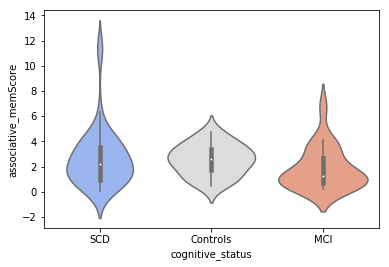

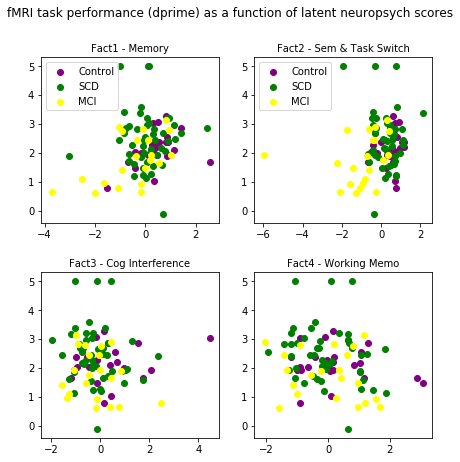

[[1.        0.2489455]
 [0.2489455 1.       ]]
[[1.         0.15936388]
 [0.15936388 1.        ]]
[[ 1.         -0.08082608]
 [-0.08082608  1.        ]]
[[ 1.         -0.19149119]
 [-0.19149119  1.        ]]


In [108]:
# load dataset
demo_stuff = pd.read_csv('/Users/mombot/Documents/Simexp/CIMAQ/Data/Participants/Splitting/Sub_list.tsv', sep = '\t')

# only keep participants whose fMRI data is useable
demo_stuff = demo_stuff[demo_stuff['QC_status']!= 'F']

demo_stuff.insert(loc = demo_stuff.shape[1], column = '1Ctl_2SDC_3MCI', value = 0, allow_duplicates=True)

ind = demo_stuff[demo_stuff['cognitive_status']=='Controls'].index
demo_stuff.loc[ind, '1Ctl_2SDC_3MCI']=1
ind = demo_stuff[demo_stuff['cognitive_status']=='SCD'].index
demo_stuff.loc[ind, '1Ctl_2SDC_3MCI']=2
ind = demo_stuff[demo_stuff['cognitive_status']=='MCI'].index
demo_stuff.loc[ind, '1Ctl_2SDC_3MCI']=3

#print(demo_stuff.dtypes)

#Bar graph: number of participants per diagnostic group
#plt.bar(x = demo_stuff['Fac1_memory'], )

print(demo_stuff.cognitive_status.value_counts())

# violin plots
# check also in matplotlib: https://matplotlib.org/3.1.1/gallery/statistics/customized_violin.html

# Generate scatterplots: Training data (mean CV)
fs = 10 # font size
pos = [1, 2, 3] # split distribution per group ?

#Latent scores: Fac1_memory, Fac2_semantics_and_taskSwitching, Fac3_CogInterference, Fac4_workMemo
#Task performance: dprime, associative_memScore
sns.set_palette("coolwarm", 3)
sns.violinplot(x = demo_stuff['cognitive_status'], y = demo_stuff['associative_memScore'], widths=0.5, 
               showmeans=True, showextrema=True, showmedians=True, fs = 14)
#fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(6, 6))
#axes.Axes.violinplot()
predicted = 'dprime'

demo_ctl = demo_stuff[demo_stuff['cognitive_status']=='Controls'].copy()
demo_scd = demo_stuff[demo_stuff['cognitive_status']=='SCD'].copy()
demo_mci = demo_stuff[demo_stuff['cognitive_status']=='MCI'].copy()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(7, 7))
axes[0, 0].scatter(demo_ctl['Fac1_memory'], demo_ctl[predicted], label = 'Control', c='purple')
axes[0, 0].scatter(demo_scd['Fac1_memory'], demo_scd[predicted], label = 'SCD', c='green')
axes[0, 0].scatter(demo_mci['Fac1_memory'], demo_mci[predicted], label = 'MCI', c='yellow')
axes[0, 0].legend()
axes[0, 0].set_title('Fact1 - Memory', fontsize=fs)
axes[0, 1].scatter(demo_ctl['Fac2_semantics_and_taskSwitching'], demo_ctl[predicted], label = 'Control', c='purple')
axes[0, 1].scatter(demo_scd['Fac2_semantics_and_taskSwitching'], demo_scd[predicted], label = 'SCD', c='green')
axes[0, 1].scatter(demo_mci['Fac2_semantics_and_taskSwitching'], demo_mci[predicted], label = 'MCI', c='yellow')
axes[0, 1].legend()
axes[0, 1].set_title('Fact2 - Sem & Task Switch', fontsize=fs)
axes[1, 0].scatter(demo_ctl['Fac3_CogInterference'], demo_ctl[predicted], label = 'Control', c='purple')
axes[1, 0].scatter(demo_scd['Fac3_CogInterference'], demo_scd[predicted], label = 'SCD', c='green')
axes[1, 0].scatter(demo_mci['Fac3_CogInterference'], demo_mci[predicted], label = 'MCI', c='yellow')
axes[1, 0].set_title('Fact3 - Cog Interference', fontsize=fs)
axes[1, 1].scatter(demo_ctl['Fac4_workMemo'], demo_ctl[predicted], label = 'Control', c='purple')
axes[1, 1].scatter(demo_scd['Fac4_workMemo'], demo_scd[predicted], label = 'SCD', c='green')
axes[1, 1].scatter(demo_mci['Fac4_workMemo'], demo_mci[predicted], label = 'MCI', c='yellow')
axes[1, 1].set_title('Fact4 - Working Memo', fontsize=fs)

fig.suptitle('fMRI task performance (dprime) as a function of latent neuropsych scores')
fig.subplots_adjust(hspace=0.3)
plt.show()

print(np.corrcoef(demo_stuff['Fac1_memory'], demo_stuff[predicted]))
print(np.corrcoef(demo_stuff['Fac2_semantics_and_taskSwitching'], demo_stuff[predicted]))
print(np.corrcoef(demo_stuff['Fac3_CogInterference'], demo_stuff[predicted]))
print(np.corrcoef(demo_stuff['Fac4_workMemo'], demo_stuff[predicted]))

(96, 7) Model            object
Analysis         object
Parcellation     object
Accuracy        float64
Dev             float64
Set              object
Position          int64
dtype: object


[]

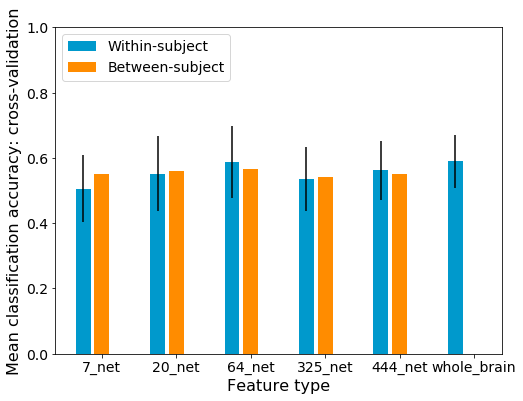

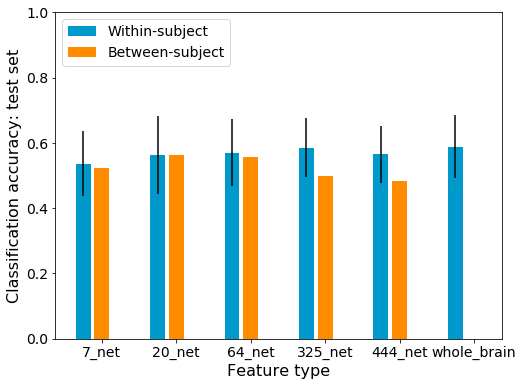

In [109]:
# Load summary table
sub_tab = pd.read_csv('/Users/mombot/Documents/Simexp/CIMAQ/Presentation/Sum_table.tsv', sep = '\t')
print(sub_tab.shape, sub_tab.dtypes)

#classi = 'enc_ctl'
#classi = 'hit_miss'
#classi = 'cs_ws'
classi = 'cs_miss'

sub_tab = sub_tab[sub_tab['Model']==classi].copy()

## Bar plot of classification accuracy per type of analysis (between & within), per parcellation

train_tab = sub_tab[sub_tab['Set']=='CV_train'].copy()
train_b = train_tab[train_tab['Analysis']=='between_sub'].copy()
train_w = train_tab[train_tab['Analysis']=='within_sub'].copy()
#print(train_tab)
test_tab = sub_tab[sub_tab['Set']=='test'].copy()
test_b = test_tab[test_tab['Analysis']=='between_sub'].copy()
test_w = test_tab[test_tab['Analysis']=='within_sub'].copy()
#print(test_tab)

# Bar plot of training data accuracy
x_w_train = train_w['Position'].to_list()
h_w_train = train_w['Accuracy'].to_list()
bar_w_train = train_w['Dev'].to_list()

train_b['Position'] = train_b['Position'] + 0.25
x_b_train = train_b['Position'].to_list()
h_b_train = train_b['Accuracy'].to_list()

labs = train_w['Parcellation'].to_list()

f, ax = plt.subplots(figsize=(8,6))
plt.bar(x_w_train, h_w_train, label = 'Within-subject', color = (0, .6, .8), width=0.2, yerr = bar_w_train)
plt.bar(x_b_train, h_b_train, label = 'Between-subject', color = 'darkorange', width=0.2, tick_label = labs)
plt.ylim(0, 1)
plt.ylabel('Mean classification accuracy: cross-validation', fontsize= 16)
plt.xlabel('Feature type', fontsize=16)
plt.tick_params(labelsize=14)
plt.legend(loc = 'upper left', fontsize=14)
plt.plot()


# Bar plot of testing data accuracy
x_w_test = test_w['Position'].to_list()
h_w_test = test_w['Accuracy'].to_list()
bar_w_test = test_w['Dev'].to_list()

test_b['Position'] = test_b['Position'] + 0.25
x_b_test = test_b['Position'].to_list()
h_b_test = test_b['Accuracy'].to_list()

labs = test_w['Parcellation'].to_list()

f, ax = plt.subplots(figsize=(8,6))
plt.bar(x_w_test, h_w_test, label = 'Within-subject', color = (0, .6, .8), width=0.2, yerr = bar_w_test)
plt.bar(x_b_test, h_b_test, label = 'Between-subject', color = 'darkorange', width=0.2, tick_label = labs)
plt.ylim(0, 1)
plt.ylabel('Classification accuracy: test set', fontsize= 16)
plt.xlabel('Feature type', fontsize=16)
plt.tick_params(labelsize=14)
plt.legend(loc = 'upper left', fontsize=14)
plt.plot()


Histogram
between- and (averaged) within- subject classification accuracy, as a function of features (parcellation)


within-subject classification accuracy per diagnostic group?? violin plots

Within-subject performance : d-prime, associative memory score, as function of diag group
(violin plot)

Scatterplots
classification accuracy as function of 
- task performance (dprime, asso memory score): NOT
- motion (mean FD, number of scrubbed frames): a bit
- number of trials of interest (2 categories)
- difference in number of trials between 2 categories of interest?
- ?neuropsych (latent memo score; need to add to dataframe...)

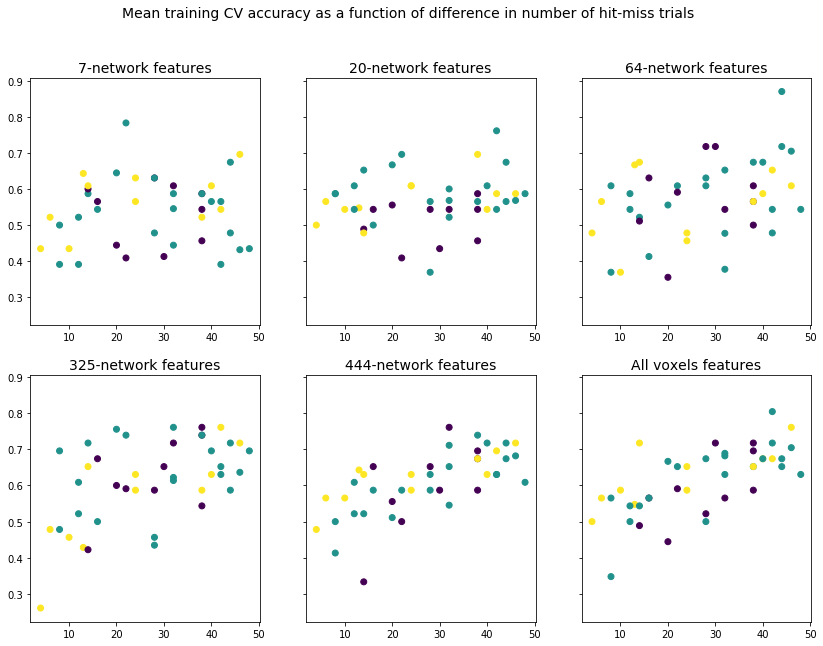

7 [[1.         0.09693671]
 [0.09693671 1.        ]]
20 [[1.         0.18877688]
 [0.18877688 1.        ]]
64 [[1.         0.37594265]
 [0.37594265 1.        ]]
325 [[1.        0.5268233]
 [0.5268233 1.       ]]
444 [[1.         0.67272058]
 [0.67272058 1.        ]]
WB [[1.         0.67896604]
 [0.67896604 1.        ]]


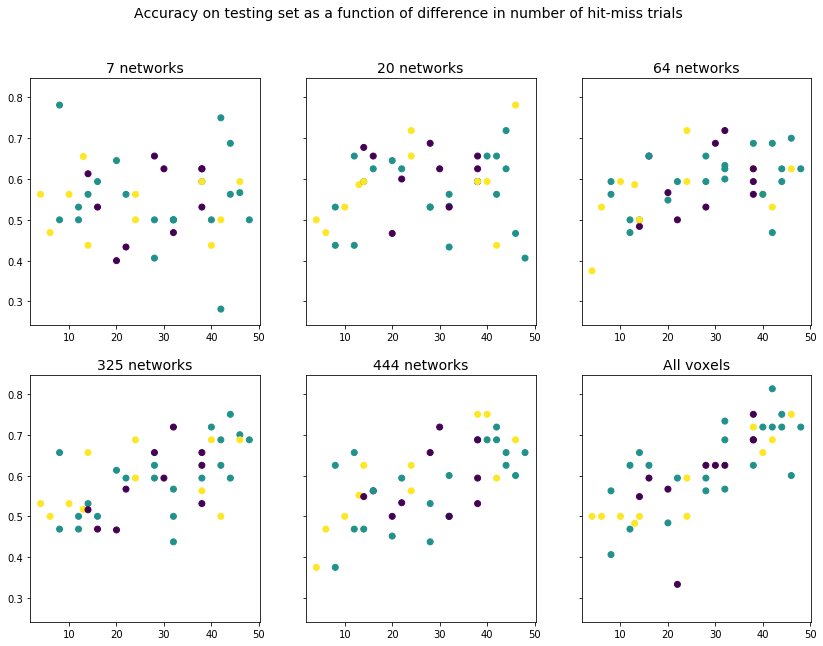

7 [[ 1.         -0.02490838]
 [-0.02490838  1.        ]]
20 [[1.         0.16057895]
 [0.16057895 1.        ]]
64 [[1.         0.44090386]
 [0.44090386 1.        ]]
325 [[1.         0.55896373]
 [0.55896373 1.        ]]
444 [[1.         0.61873413]
 [0.61873413 1.        ]]
WB [[1.         0.75185804]
 [0.75185804 1.        ]]


In [128]:
# Set lists of analyses and variables
#d_set = enc_ctl
d_set = hit_miss
#d_set = cs_ws
#d_set = cs_miss

predictors = ['total_scrubbed_frames', 'mean_FD', 'hits', 'miss', 
        'correct_source', 'wrong_source', 'dprime', 'associative_memScore', 
             'HM_abs_diff', 'CW_abs_diff', 'CM_abs_diff']

pred_names = ['total scrubbed frames', 'mean frame displacement', 'number of hits (out of 78)', 
             'number of misses (out of 78)', 'correct source trials (max 78)', 
             'wrong source trials (max 78)', 'dprime', 'associative memory score',
             'difference in number of hit-miss trials', 'difference in number of cs-ws trials', 
             'difference in number of cs-miss trials']

# Choose predictor from list
predictor = predictors[8]
predname = pred_names[8]

# Generate scatterplots: Training data (mean CV)
fs = 14
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 10), sharey=True)

axes[0, 0].scatter(d_set[predictor], d_set['7_TrainSet_MeanCV_acc'], c=d_set['1Ctl_2SDC_3MCI'])
axes[0, 0].set_title('7-network features', fontsize=fs)
axes[0, 1].scatter(d_set[predictor], d_set['20_TrainSet_MeanCV_acc'], c=d_set['1Ctl_2SDC_3MCI'])
axes[0, 1].set_title('20-network features', fontsize=fs)
axes[0, 2].scatter(d_set[predictor], d_set['64_TrainSet_MeanCV_acc'], c=d_set['1Ctl_2SDC_3MCI'])
axes[0, 2].set_title('64-network features', fontsize=fs)
axes[1, 0].scatter(d_set[predictor], d_set['325_TrainSet_MeanCV_acc'], c=d_set['1Ctl_2SDC_3MCI'])
axes[1, 0].set_title('325-network features', fontsize=fs)
axes[1, 1].scatter(d_set[predictor], d_set['444_TrainSet_MeanCV_acc'], c=d_set['1Ctl_2SDC_3MCI'])
axes[1, 1].set_title('444-network features', fontsize=fs)
axes[1, 2].scatter(d_set[predictor], d_set['WB_TrainSet_MeanCV_acc'], c=d_set['1Ctl_2SDC_3MCI'])
axes[1, 2].set_title('All voxels features', fontsize=fs)

fig.suptitle('Mean training CV accuracy as a function of '+predname, fontsize=fs)
fig.subplots_adjust(hspace=0.2)
plt.show()

print('7', np.corrcoef(d_set['7_TrainSet_MeanCV_acc'], d_set[predictor]))
print('20', np.corrcoef(d_set['20_TrainSet_MeanCV_acc'], d_set[predictor]))
print('64', np.corrcoef(d_set['64_TrainSet_MeanCV_acc'], d_set[predictor]))
print('325', np.corrcoef(d_set['325_TrainSet_MeanCV_acc'], d_set[predictor]))
print('444', np.corrcoef(d_set['444_TrainSet_MeanCV_acc'], d_set[predictor]))
print('WB', np.corrcoef(d_set['WB_TrainSet_MeanCV_acc'], d_set[predictor]))

# Generate scatterplots: Training data (mean CV)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 10), sharey=True)

axes[0, 0].scatter(d_set[predictor], d_set['7_TestSet_acc'], c=d_set['1Ctl_2SDC_3MCI'])
axes[0, 0].set_title('7 networks', fontsize=fs)
axes[0, 1].scatter(d_set[predictor], d_set['20_TestSet_acc'], c=d_set['1Ctl_2SDC_3MCI'])
axes[0, 1].set_title('20 networks', fontsize=fs)
axes[0, 2].scatter(d_set[predictor], d_set['64_TestSet_acc'], c=d_set['1Ctl_2SDC_3MCI'])
axes[0, 2].set_title('64 networks', fontsize=fs)
axes[1, 0].scatter(d_set[predictor], d_set['325_TestSet_acc'], c=d_set['1Ctl_2SDC_3MCI'])
axes[1, 0].set_title('325 networks', fontsize=fs)
axes[1, 1].scatter(d_set[predictor], d_set['444_TestSet_acc'], c=d_set['1Ctl_2SDC_3MCI'])
axes[1, 1].set_title('444 networks', fontsize=fs)
axes[1, 2].scatter(d_set[predictor], d_set['WB_TestSet_acc'], c=d_set['1Ctl_2SDC_3MCI'])
axes[1, 2].set_title('All voxels', fontsize=fs)

fig.suptitle('Accuracy on testing set as a function of '+predname, fontsize=fs)
fig.subplots_adjust(hspace=0.2)
plt.show()

print('7', np.corrcoef(d_set['7_TestSet_acc'], d_set[predictor]))
print('20', np.corrcoef(d_set['20_TestSet_acc'], d_set[predictor]))
print('64', np.corrcoef(d_set['64_TestSet_acc'], d_set[predictor]))
print('325', np.corrcoef(d_set['325_TestSet_acc'], d_set[predictor]))
print('444', np.corrcoef(d_set['444_TestSet_acc'], d_set[predictor]))
print('WB', np.corrcoef(d_set['WB_TestSet_acc'], d_set[predictor]))

#fig.xlabel(predname)
#plt.ylabel('Mean training CV accuracy')

#plt.legend()
#fig, ax = plt.subplots()
#legend = ax.legend(*scatter.legend_elements(),
#                    loc="upper right", title="Legend")
#plt.add_artist(legend)

#plt.scatter(d_set['total_scrubbed_frames'], d_set['7_TestSet_acc'])


